### [Ensembles](https://scikit-learn.org/stable/modules/ensemble.html)
- Averaging methods - build multiple independent estimators, then average their predictions.

### [Bagging Methods](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html#sklearn.ensemble.BaggingClassifier)
- Bagging methods build multiple "black box" estimators using *random subsets* of a training dataset, then aggregate the predictions. 
- Effective on complex models (ie, fully developed decison trees).
- Variations usually occur in the random subset selection process:

    - *Pasting*: random subsets as, well, random subsets.
    - *Bagging*: samples are drawn *with replacement*.
    - *Random Subspaces*: random subsets are drawn as random subsets of the features.
    - *Random Patches*: when base estimators are built on random subsets of both samples and features.
    
- Bagging estimators are built using the Bagging meta-estimator with a user-specified estimator & subset selection parameters:
    - `max_samples`: controls sample subset size
    - `max_features`: controls feature subset size
    - `bootstrap`: controls whether samples are drawn with/without replacement
    - `boostrap_features`: controls whether features are drawn with/without replacement
    - `oob_score=True`: When using a subset of samples, the generalization accuracy can be estimated with out-of-bag samples.

In [1]:
# instantiate a K neighbors classifier,
# built using 50% of the samples, 50% of the features.
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
bagging = BaggingClassifier(KNeighborsClassifier(),
                            max_samples=0.5, max_features=0.5)

### Example: Single estimator vs Bagging
- Illustrates the bias-variance relation of an Expected Mean Squared Error, single estimator vs a bagging ensemble.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import BaggingRegressor as Bagger
from sklearn.tree import DecisionTreeRegressor as Tree

In [3]:
n_repeat = 50       # Number of iterations for computing expectations
n_train = 50        # Size of the training set
n_test = 1000       # Size of the test set
noise = 0.1         # Standard deviation of the noise
np.random.seed(0)

estimators = [("Tree", Tree()),
              ("Bagging(Tree)", Bagger(Tree()))]

n_estimators = len(estimators)

In [4]:
def f(x):
    x = x.ravel()
    return np.exp(-x ** 2) + 1.5 * np.exp(-(x - 2) ** 2)

def generate(n_samples, noise, n_repeat=1):
    X = np.random.rand(n_samples) * 10 - 5
    X = np.sort(X)

    if n_repeat == 1:
        y = f(X) + np.random.normal(0.0, noise, n_samples)
    else:
        y = np.zeros((n_samples, n_repeat))

        for i in range(n_repeat):
            y[:, i] = f(X) + np.random.normal(0.0, noise, n_samples)

    X = X.reshape((n_samples, 1))
    return X, y

X_train, y_train = [],[]

In [5]:
for i in range(n_repeat):
    X, y = generate(n_samples=n_train, noise=noise)
    X_train.append(X)
    y_train.append(y)

X_test, y_test = generate(n_samples=n_test, noise=noise, n_repeat=n_repeat)


- **Upper left**: predictions (dark red) of a single decision tree.
    - Trained on a random dataset (blue dots) from a toy 1D regression.
    - Variance corresponds to the *width of the beam of predictions* (light red).
    - The larger the variance = the more sensitivity of `x` to the training data.
    - Bias corresponds to the *difference between average estimator prediction* (cyan) and the best possible model (dark blue).
    - Observed bias is quite low (cyan & blue curves close together)
    - Observed variance is high (red beam is wide)
    

- **Lower left**: pointwise decomposition of the expected MSE of a single decision tree.
    - Confirms the bias (blue) is low, while variance (gree) is large.
    - Confirms the noise component is a relatively constant 0.01.
    
    
- **Upper & lower right**: same plots, based on a bagging ensemble of decision trees.

- Total error of the bagging ensemble is lower than the single decision tree - mainly due to the reduced variance.

Tree: 0.0255 (error) = 0.0003 (bias^2)  + 0.0152 (var) + 0.0098 (noise)
Bagging(Tree): 0.0196 (error) = 0.0004 (bias^2)  + 0.0092 (var) + 0.0098 (noise)


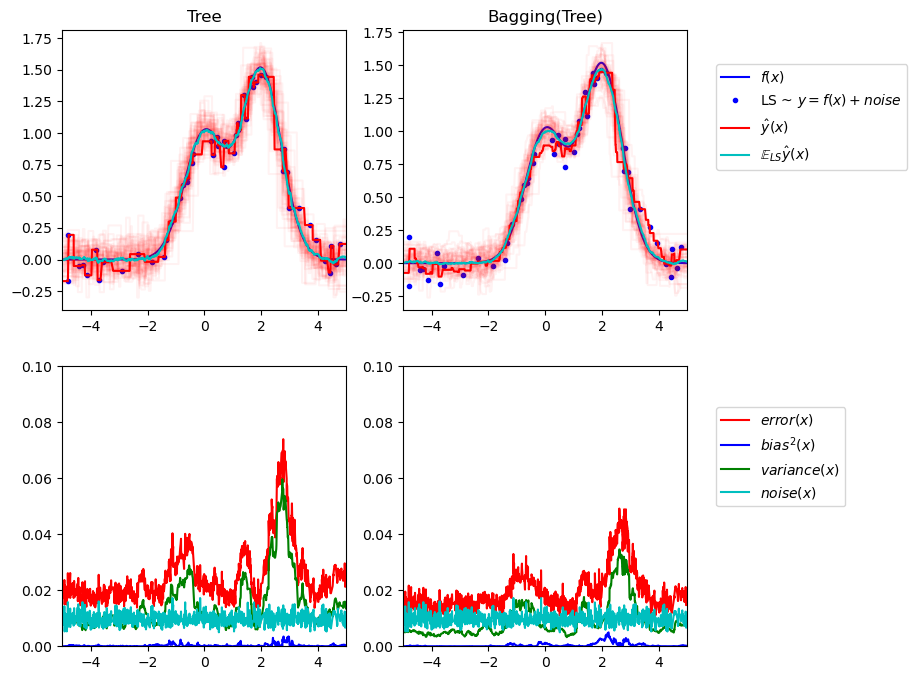

In [6]:
plt.figure(figsize=(10, 8))

# Loop over estimators to compare
for n, (name, estimator) in enumerate(estimators):

    y_predict = np.zeros((n_test, n_repeat))

    for i in range(n_repeat):
        estimator.fit(X_train[i], y_train[i])
        y_predict[:, i] = estimator.predict(X_test)

    # Bias^2 + Variance + Noise decomposition of the mean squared error
    y_error = np.zeros(n_test)

    for i in range(n_repeat):
        for j in range(n_repeat):
            y_error += (y_test[:, j] - y_predict[:, i]) ** 2

    y_error /= (n_repeat * n_repeat)
    y_noise  = np.var(y_test, axis=1)
    y_bias   = (f(X_test) - np.mean(y_predict, axis=1)) ** 2
    y_var    = np.var(y_predict, axis=1)

    print("{0}: {1:.4f} (error) = {2:.4f} (bias^2) "
          " + {3:.4f} (var) + {4:.4f} (noise)".format(name,
                                                      np.mean(y_error),
                                                      np.mean(y_bias),
                                                      np.mean(y_var),
                                                      np.mean(y_noise)))

    # Plot figures
    plt.subplot(2, n_estimators, n + 1)
    plt.plot(X_test, f(X_test), "b", label="$f(x)$")
    plt.plot(X_train[0], y_train[0], ".b", label="LS ~ $y = f(x)+noise$")

    for i in range(n_repeat):
        if i == 0:
            plt.plot(X_test, y_predict[:, i], "r", label=r"$\^y(x)$")
        else:
            plt.plot(X_test, y_predict[:, i], "r", alpha=0.05)

    plt.plot(X_test, np.mean(y_predict, axis=1), "c",
             label=r"$\mathbb{E}_{LS} \^y(x)$")

    plt.xlim([-5, 5])
    plt.title(name)

    if n == n_estimators - 1:
        plt.legend(loc=(1.1, .5))

    plt.subplot(2, n_estimators, n_estimators + n + 1)
    plt.plot(X_test, y_error, "r", label="$error(x)$")
    plt.plot(X_test, y_bias, "b", label="$bias^2(x)$"),
    plt.plot(X_test, y_var, "g", label="$variance(x)$"),
    plt.plot(X_test, y_noise, "c", label="$noise(x)$")

    plt.xlim([-5, 5])
    plt.ylim([0, 0.1])

    if n == n_estimators - 1:

        plt.legend(loc=(1.1, .5))

plt.subplots_adjust(right=.75)
plt.show()


### Random Forest Classifiers
- Sklearn has two averaging algorithms: [**Random Forest**](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier) and [**Extra Trees**](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html#sklearn.ensemble.ExtraTreesClassifier).
- Forest classifiers accept a training array X (#samples, #features) and a class labels array Y (#samples).
- Random Forest methods also can be used on multi-output problems if Y is expanded to (#samples, #outputs).
- Each tree is built from a sample drawn *with replacement* ("bootstrap") from the training data. Each node split is found from *either* all input features, or a random subset of size `max_features`.
- The randomness helps to decrease estimator variance - individual trees usually have high variance and tend to overfit.

In [7]:
from sklearn.ensemble import RandomForestClassifier as RFC

X,Y = [[0, 0], [1, 1]], [0, 1]

clf = RFC(n_estimators=10); clf = clf.fit(X, Y)


### Extra Trees Classifiers
- Extra Trees, aka "extremely randomized trees", take the randomness one step further.
- Instead of looking for the most discriminative thresholds, thresholds are drawn at random for each candidate feature. The best of these randomly-generated thresholds is picked as the splitting rule.
- Usually results in slightly lower variance and slightly higher bias.

In [8]:
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_blobs

from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.ensemble import ExtraTreesClassifier as ETC
from sklearn.tree import DecisionTreeClassifier as DTC

X, y = make_blobs(n_samples=10000, 
                  n_features=10, 
                  centers=100,
                  random_state=0)

dtc = DTC(                 max_depth=None, min_samples_split=2, random_state=0)
rfc = RFC(n_estimators=10, max_depth=None, min_samples_split=2, random_state=0)
etc = ETC(n_estimators=10, max_depth=None, min_samples_split=2, random_state=0)

dtc_scores = cross_val_score(dtc, X, y, cv=5)
rfc_scores = cross_val_score(rfc, X, y, cv=5)
etc_scores = cross_val_score(etc, X, y, cv=5)

print(dtc_scores.mean())
print(rfc_scores.mean())
print(etc_scores.mean() > 0.999)

0.9823000000000001
0.9997
True


### Parameters
- `n_estimators` (#trees in the forest) and `max_features` (#random feature subsets used for node splits) are the main params.
- More trees is better, but will take longer to compute - and results will eventually plateau.
- Smaller `#max_features`means more reduction of variance, but also greater bias.
- Good starting points:
    - `max_features=None` (always considering all features) for regressions
    - `max_features="sqrt"` (use random subset of size `sqrt(n_features)` for classifications.
    
    
- Always consider using CV to pick param values.
- Default bootstrap sample strategy:
    - yes for Random Forests (`bootstrap=True`)
    - no (instead use entire dataset) for Extra Trees (`bootstrap=False`)



- Model size with default settings: $O(M*N*log(N))$ where $M$ = #trees, $N$ = #samples
    - use `min_samples_split`, `max_leaf_nodes`, `max_depth` and `min_samples_leaf` to reduce model size if needed.

### Parallel Execution
- `n_jobs=k` enables parallel tree construction & prediction computation, where $k$ is the #jobs to run on $k$ cpu cores. (If `n_jobs=-1`, all available cores will be used.)
- The speedup will not be linear due to inter-cpu communication latencies.

### Feature Importance
- The **rank** (aka depth) of a feature can signal its importance to prediction accuracy.
- Features at the top of a tree contribute to the decision in a larger fraction of inputs, so the **expected fraction of samples** can be used as an importance measure.
- Scikit-Learn combines this with the **decrease in impurity from splitting** to create a normalized estimate.
- Averaging these estimates across multiple trees (aka "mean decrease in impurity", "MDI") can reduce variance.
- MDI values computed from training data don't necessarily translate to features in held-out datasets. They also *favor high-cardinality* (many unique values) *features*.
- **[Permutation Feature Importance](https://scikit-learn.org/stable/modules/permutation_importance.html#permutation-importance)** is an alternative approach that doesn't have these flaws.
- The estimates are stored in `feature_importances_` - an array of #features with all positive values summing to 1.0.

### Example: Pixel importance, Extra Trees

In [9]:
from time import time
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_olivetti_faces as FOF
from sklearn.ensemble import ExtraTreesClassifier as ETC

n_jobs = 1
data = FOF(); X, y = data.data, data.target

mask = y<5; X = X[mask]; y = y[mask] # limit to 5 classes

# Build a forest and compute the pixel importances
print("Fitting on faces data with %d cores..." % n_jobs)
t0 = time()
forest = ETC(n_estimators=1000,
             max_features=128,
             n_jobs=n_jobs,
             random_state=0); forest.fit(X, y)

print("done in %0.3fs" % (time() - t0))
importances = forest.feature_importances_
importances = importances.reshape(data.images[0].shape)

Fitting on faces data with 1 cores...
done in 0.778s


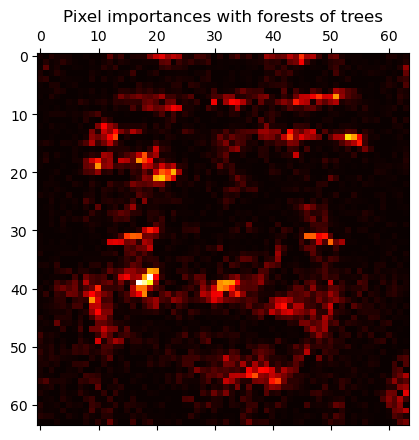

In [11]:
plt.matshow(importances, cmap=plt.cm.hot)
plt.title("Pixel importances with forests of trees"); plt.show()

### Feature importance, Extra Trees
- red bars: impurity-based feature importance, plus inter-tree variability.
- plot suggest 3 informative features.

In [12]:
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier as ETC

# Build a classification task using 3 informative features
X, y = make_classification(n_samples=1000,
                           n_features=10,
                           n_informative=3,
                           n_redundant=0,
                           n_repeated=0,
                           n_classes=2,
                           random_state=0,
                           shuffle=False)

In [13]:
import numpy as np
forest = ETC(n_estimators=250, random_state=0)

forest.fit(X, y)
importances = forest.feature_importances_
std         = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices     = np.argsort(importances)[::-1]

print("Feature ranking:")
for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

Feature ranking:
1. feature 1 (0.295902)
2. feature 2 (0.208351)
3. feature 0 (0.177632)
4. feature 3 (0.047121)
5. feature 6 (0.046303)
6. feature 8 (0.046013)
7. feature 7 (0.045575)
8. feature 4 (0.044614)
9. feature 9 (0.044577)
10. feature 5 (0.043912)


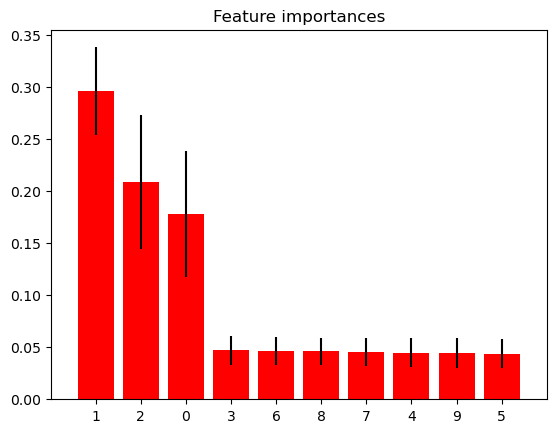

In [14]:
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), 
        importances[indices],
        color="r", yerr=std[indices], align="center")

plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

### [Random Tree Embedding](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomTreesEmbedding.html#sklearn.ensemble.RandomTreesEmbedding)
- Computes an unsupervised data transformation with completely random trees.
- It encodes data using the leaf indice where it eventually resides.
- The index is one-of-K encoded - leading to high-dimensional, sparse binary coding - which can be used as the basis for further learning.
- Given that neighboring data is more likely to reside in the same leaves, the transform effectively does a non-parametric density estimate.

### Example: Hashing feature transform using Random Tree Embedding

In [15]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_circles
from sklearn.ensemble import RandomTreesEmbedding as RTE, ExtraTreesClassifier as ETC
from sklearn.decomposition import TruncatedSVD
from sklearn.naive_bayes import BernoulliNB

In [16]:
# make a synthetic dataset
X, y = make_circles(factor=0.5, random_state=0, noise=0.05)

# use RandomTreesEmbedding to transform data
hasher        = RTE(n_estimators=10, random_state=0, max_depth=3)
X_transformed = hasher.fit_transform(X)
svd           = TruncatedSVD(n_components=2) # for visualizing after dimensional reduction
X_reduced     = svd.fit_transform(X_transformed)

# compare Naive Bayes (on transformed data) & Extra Trees classifier (on original) 
nb            = BernoulliNB()
trees         = ETC(max_depth=3, n_estimators=10, random_state=0)

nb.fit(X_transformed, y)
trees.fit(X, y)

ExtraTreesClassifier(max_depth=3, n_estimators=10, random_state=0)

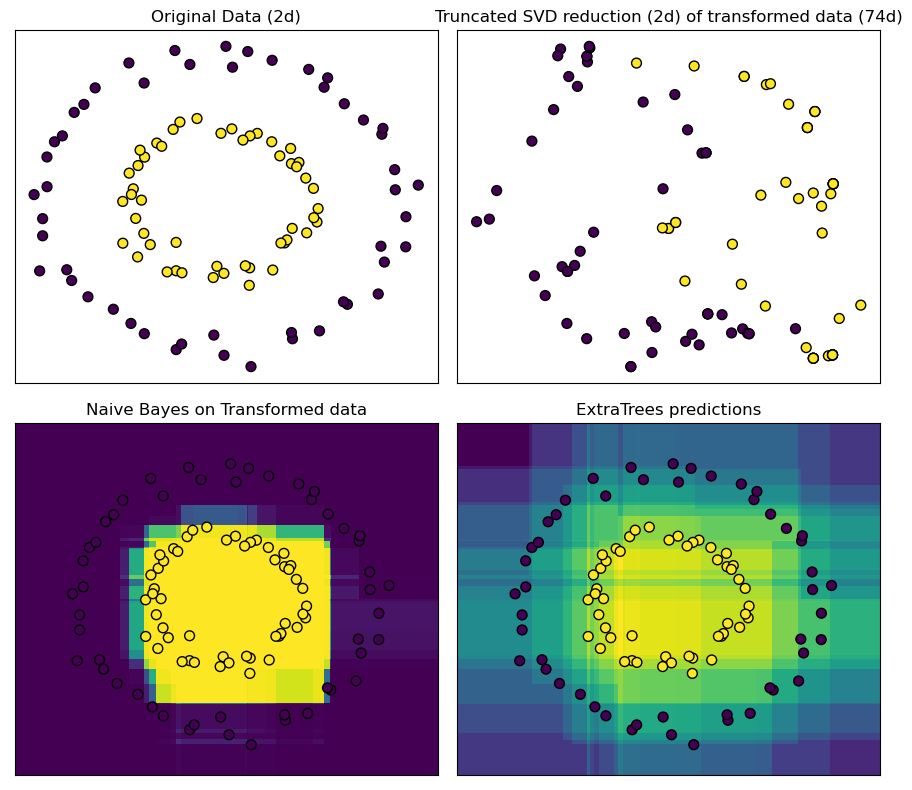

In [17]:
# scatter plot of original and reduced data
fig = plt.figure(figsize=(9, 8))

ax = plt.subplot(221)
ax.scatter(X[:, 0], X[:, 1], c=y, s=50, edgecolor='k')
ax.set_title("Original Data (2d)")
ax.set_xticks(())
ax.set_yticks(())

ax = plt.subplot(222)
ax.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, s=50, edgecolor='k')
ax.set_title("Truncated SVD reduction (2d) of transformed data (%dd)" % X_transformed.shape[1])
ax.set_xticks(())
ax.set_yticks(())

# Plot decision in original space. Assign a color to each point in the mesh.
h = .01
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), 
                     np.arange(y_min, y_max, h))

# transform grid using RandomTreesEmbedding
transformed_grid = hasher.transform(np.c_[xx.ravel(), yy.ravel()])
y_grid_pred = nb.predict_proba(transformed_grid)[:, 1]

ax = plt.subplot(223)
ax.set_title("Naive Bayes on Transformed data")
ax.pcolormesh(xx, yy, y_grid_pred.reshape(xx.shape), shading='auto')
ax.scatter(X[:, 0], X[:, 1], c=y, s=50, edgecolor='k')
ax.set_ylim(-1.4, 1.4)
ax.set_xlim(-1.4, 1.4)
ax.set_xticks(())
ax.set_yticks(())

# transform grid using ExtraTreesClassifier
y_grid_pred = trees.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

ax = plt.subplot(224)
ax.set_title("ExtraTrees predictions")
ax.pcolormesh(xx, yy, y_grid_pred.reshape(xx.shape), shading='auto')
ax.scatter(X[:, 0], X[:, 1], c=y, s=50, edgecolor='k')
ax.set_ylim(-1.4, 1.4)
ax.set_xlim(-1.4, 1.4)
ax.set_xticks(())
ax.set_yticks(())

plt.tight_layout()
plt.show()